In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
eps = np.finfo(float).eps
from numpy import log2 as log


df = pd.read_csv("play_tennis.csv")
df.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


In [ ]:
df = df.drop('day', axis=1)

In [ ]:
df.head()

,outlook,temp,humidity,wind,play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [ ]:
def find_entropy(df):
  target = df.keys()[-1]
  entropy = 0
  values = df[target].unique()


  for value in values:
    fraction = df[target].value_counts()[value]/len(df[target])

    entropy += -fraction * log(fraction)
  return entropy

print(find_entropy(df))

0.9402859586706311


In [ ]:
def average_information(df,attribute):
  target = df.keys()[-1]   #target column
  target_variables = df[target].unique()  #This gives all 'Yes' and 'No'
  variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
  entropy2 = 0
  for variable in variables:
      entropy = 0
      for target_variable in target_variables:
          num = len(df[attribute][df[attribute]==variable][df[target] ==target_variable])
          den = len(df[attribute][df[attribute]==variable])
          fraction = num/(den+eps)
          entropy += -fraction*log(fraction+eps)
      fraction2 = den/len(df)
      entropy2 += -fraction2*entropy
  return abs(entropy2)



0.9110633930116756


In [ ]:
def find_winner(df):
    IG = []
    for key in df.keys()[:-1]:
        IG.append(find_entropy(df)-average_information(df,key))
    return df.keys()[:-1][np.argmax(IG)]

In [ ]:
def get_subtable(df, node,value):
  return df[df[node] == value].reset_index(drop=True)

In [ ]:
def buildTree(df,tree=None):
    target = df.keys()[-1]   #target column

    #Here we build our decision tree

    #Get attribute with maximum information gain
    node = find_winner(df)

    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])

    #Create an empty dictionary to create tree
    if tree is None:
        tree={}
        tree[node] = {}

    #We make loop to construct a tree by calling this function recursively.
    #In this we check if the subset is pure and stops if it is pure.

    for value in attValue:

        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable[target],return_counts=True)

        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]
        else:
            tree[node][value] = buildTree(subtable) #Calling the function recursively

    return tree

In [ ]:
tree = buildTree(df)

import pprint
pprint.pprint(tree)

{'outlook': {'Overcast': 'Yes',
             'Rain': {'wind': {'Strong': 'No', 'Weak': 'Yes'}},
             'Sunny': {'humidity': {'High': 'No', 'Normal': 'Yes'}}}}


In [ ]:
def print_binary_tree(node, level=0, prefix="Root: "):
    """Recursively prints a dictionary-based binary tree in a structured format."""
    if isinstance(node, dict):
        for key in node:
            print(" " * (4 * level) + prefix + str(key))
            print_binary_tree(node[key], level + 1, "L-- " if not prefix.startswith("R") else "R-- ")
    else:
        print(" " * (4 * level) + prefix + str(node))  # Print leaf node

print_binary_tree(tree)

Root: outlook
    R-- Overcast
        R-- Yes
    R-- Rain
        R-- wind
            R-- Strong
                R-- No
            R-- Weak
                R-- Yes
    R-- Sunny
        R-- humidity
            R-- High
                R-- No
            R-- Normal
                R-- Yes


In [ ]:
def classify(sample, tree):
    """Classifies a new sample based on the built decision tree."""
    if not isinstance(tree, dict):  # If the tree is a leaf node, return classification
        return tree

    root = next(iter(tree))  # Get the root node (attribute)

    if sample[root] not in tree[root]:  # If value not found in tree (edge case)
        return "Unknown"  # Or handle differently

    subtree = tree[root][sample[root]]  # Move to the next node in the tree

    return classify(sample, subtree)  # Recursively classify the sample

In [ ]:
sample = {'outlook': 'overcast', 'humidity': 'high', 'wind': 'strong'}

In [ ]:
result = classify(sample, tree)
print("Predicted Class:", result)

Predicted Class: Unknown


In [ ]:
def classify(sample, tree):
    """Classifies a new sample based on the built decision tree."""
    if not isinstance(tree, dict):  # If it's a leaf node, return classification
        return tree

    root = next(iter(tree))  # Get the first attribute (root node)

    if root.lower() not in map(str.lower, sample.keys()):
        return "Unknown (Attribute missing in sample)"

    # Find the correct key in sample (case-insensitive match)
    matching_key = next(k for k in sample if k.lower() == root.lower())
    value = sample[matching_key]

    if value not in tree[root]:
        return "Unknown (Value not found in tree)"

    # Recursively classify based on subtree
    return classify(sample, tree[root][value])



# Example Test Samples (Ensure lowercase keys)
sample1 = {'Outlook': 'Sunny', 'Humidity': 'High', 'Wind': 'Strong'}
sample2 = {'Outlook': 'Rain', 'Wind': 'Weak'}
sample3 = {'Outlook': 'Overcast', 'Wind': 'Strong'}  # Unseen value

# Classify samples
print("Predicted Class for Sample 1:", classify(sample1, tree))  # Expected: No
print("Predicted Class for Sample 2:", classify(sample2, tree))  # Expected: Yes
print("Predicted Class for Sample 3:", classify(sample3, tree))  # Expected: Unknown


Predicted Class for Sample 1: No
Predicted Class for Sample 2: Yes
Predicted Class for Sample 3: Yes


----- ID3 Decision Tree (sklearn) -----
Accuracy: 0.9777777777777777

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      1.00      0.96        13
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45

Confusion Matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  1 12]]

Decision Tree Structure:

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.75
|   |   |--- petal width (cm) <= 1.60
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  1.60
|   |   |   |--- class: 2
|   |--- petal length (cm) >  4.75
|   |   |--- petal length (cm) <= 5.15
|   |   |   |--- petal width (cm) <= 1.75
|   |   |   |   |--- sepal width (cm) <= 2.35
|   |   |   |   |   |--- class: 2
|  

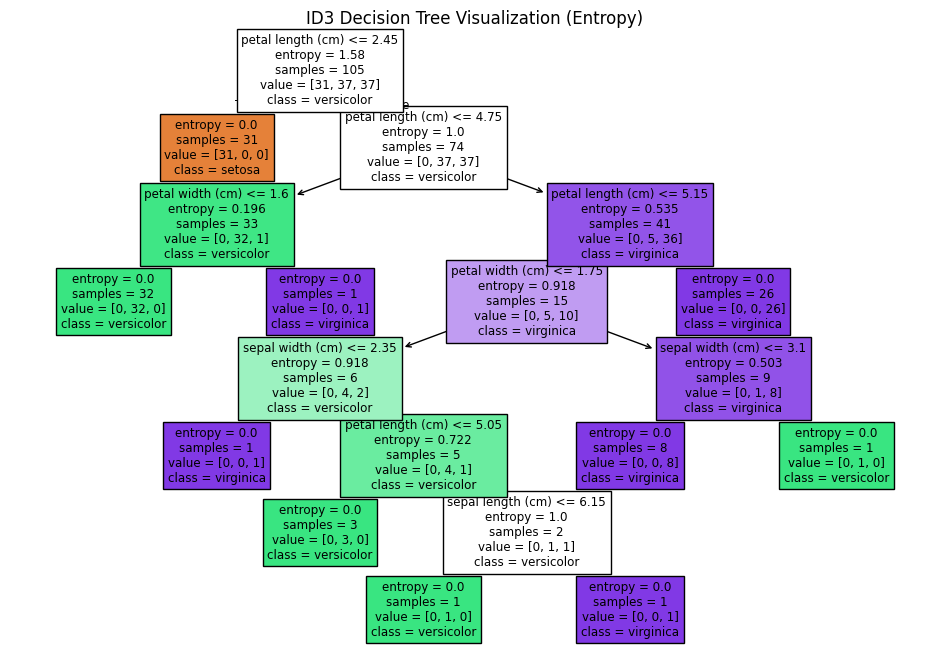

In [2]:
# decision_tree_id3.py

import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Load dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')

# Optional: Save to CSV
# pd.concat([X, y], axis=1).to_csv("iris.csv", index=False)

# Step 2: Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Create Decision Tree model (ID3-like using entropy)
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X_train, y_train)

# Step 4: Predict
y_pred = model.predict(X_test)

# Step 5: Evaluation
print("----- ID3 Decision Tree (sklearn) -----")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 6: Print the decision tree rules (text format)
print("\nDecision Tree Structure:\n")
print(export_text(model, feature_names=list(X.columns)))

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Step 7: Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=X.columns, class_names=iris.target_names, filled=True)
plt.title("ID3 Decision Tree Visualization (Entropy)")
plt.show()



In [4]:
# id3_manual.py

import pandas as pd
import numpy as np
import math

# Entropy calculation
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    return -np.sum([(counts[i]/np.sum(counts)) * math.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])

# Info gain calculation
def info_gain(data, split_attribute_name, target_name):
    total_entropy = entropy(data[target_name])
    values, counts = np.unique(data[split_attribute_name], return_counts=True)

    weighted_entropy = np.sum([
        (counts[i]/np.sum(counts)) * entropy(data[data[split_attribute_name] == values[i]][target_name])
        for i in range(len(values))
    ])

    return total_entropy - weighted_entropy

# ID3 algorithm
def id3(data, original_data, features, target_attribute_name, parent_node_class=None):
    # If all target values are same, return that label
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]

    # If dataset is empty, return most common label from original
    elif len(data) == 0:
        return np.unique(original_data[target_attribute_name])[np.argmax(
            np.unique(original_data[target_attribute_name], return_counts=True)[1])]

    # If no more features, return majority class
    elif len(features) == 0:
        return parent_node_class

    else:
        # Majority class at current node
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(
            np.unique(data[target_attribute_name], return_counts=True)[1])]

        # Best feature
        item_values = [info_gain(data, feature, target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]

        tree = {best_feature: {}}
        features = [f for f in features if f != best_feature]

        for value in np.unique(data[best_feature]):
            sub_data = data[data[best_feature] == value]
            subtree = id3(sub_data, data, features, target_attribute_name, parent_node_class)
            tree[best_feature][value] = subtree

        return tree


from graphviz import Digraph

def visualize_tree(tree, parent_name='', graph=None, node_id=0):
    if graph is None:
        graph = Digraph()
        graph.attr('node', shape='box')
        node_id = 0

    if isinstance(tree, dict):
        for attribute, branches in tree.items():
            for value, subtree in branches.items():
                node_label = f"{attribute} = {value}"
                child_name = f"node{node_id + 1}"
                graph.node(child_name, label=node_label)
                if parent_name:
                    graph.edge(parent_name, child_name)
                graph = visualize_tree(subtree, child_name, graph, node_id + 1)
    else:
        leaf_name = f"leaf{node_id}"
        graph.node(leaf_name, label=f"Class: {tree}", style='filled', fillcolor='lightgrey')
        if parent_name:
            graph.edge(parent_name, leaf_name)

    return graph

# Example usage with a small dataset
if __name__ == "__main__":
    # Weather dataset (categorical only)
    df = pd.DataFrame({
        'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain'],
        'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild'],
        'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal'],
        'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Strong'],
        'PlayTennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes']
    })

    features = list(df.columns)
    features.remove('PlayTennis')

    tree = id3(df, df, features, 'PlayTennis')
    print("----- Manual ID3 Decision Tree -----")
    from pprint import pprint
    pprint(tree)
    # Visualize the manual tree
    graph = visualize_tree(tree)
    graph.render("manual_id3_tree", format="png", cleanup=False)
    print("Manual ID3 tree saved as manual_id3_tree.png")



----- Manual ID3 Decision Tree -----
{'Outlook': {'Overcast': 'Yes',
             'Rain': {'Temperature': {'Cool': {'Wind': {'Strong': 'No',
                                                        'Weak': 'Yes'}},
                                      'Mild': 'Yes'}},
             'Sunny': {'Temperature': {'Cool': 'Yes',
                                       'Hot': 'No',
                                       'Mild': 'No'}}}}
Manual ID3 tree saved as manual_id3_tree.png
